In [22]:
# --- Cell 1: Install Required Packages ---
# This cell handles package installation *before* any imports.

import sys
import subprocess
import importlib

def install_package(package):
    """Installs a package using pip, handling potential errors."""
    try:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ Successfully installed {package}")
        return True  # Indicate success
    except subprocess.CalledProcessError as e:
        print(f"❌ Failed to install {package}: {e}")
        # Specific handling for cugraph failure and CUDA check
        if "cugraph" in package:
            print("⚠️ cuGraph installation failed.  Make sure CUDA is installed correctly and accessible.")
            print("   See https://rapids.ai/start.html for CUDA installation instructions.") #Link to CUDA installation instructions.
        return False  # Indicate failure
    except Exception as e:
        print(f"⚠️ Unexpected error installing {package}: {e}")
        return False

# List of required packages.  Make sure these versions are compatible!
required_packages = [
    "python-arango", # Consider specifying a version here, like "python-arango==8.1.6"
    "networkx>=3.0",  # Explicitly require NetworkX 3.0 or later
    "pandas",          # Consider specifying a version
    "tqdm",            # Consider specifying a version
    "langchain-cohere",  # Use the dedicated package
    "langchain-community",
    "langchain",
    "matplotlib",      # Consider specifying a version
    "python-louvain", #For community detection
    "requests", #required for gdown
    "httpx-sse", #needed by langchain
    "openai" # Consider specifying a version
]

# Install necessary packages (only if not already installed)
all_packages_installed = True  # Track if all packages installed successfully
for package in required_packages:
    try:
        importlib.import_module(package.replace("-", "_"))  # Handle package names with hyphens
        print(f"✅ {package} is already installed")
    except ImportError:
        if not install_package(package):
            all_packages_installed = False
            print(f"ERROR: Failed to install {package}. Some functionality may not work.")

if not all_packages_installed:
    print("ERROR: Some packages failed to install. Please check error output above.")
    # Consider exiting here, or providing a way to continue without the missing packages.
    # sys.exit(1)  # Exit with an error code

Installing python-arango...
✅ Successfully installed python-arango
Installing networkx>=3.0...
✅ Successfully installed networkx>=3.0
✅ pandas is already installed
✅ tqdm is already installed
✅ langchain-cohere is already installed
✅ langchain-community is already installed
✅ langchain is already installed
✅ matplotlib is already installed
Installing python-louvain...
✅ Successfully installed python-louvain
✅ requests is already installed
✅ httpx-sse is already installed
✅ openai is already installed


In [23]:
COHERE_API_KEY = 'WcXnR3lxNWGwnoJmI2hq8CnCmPfAr8fRbFFacCsT'
ARANGO_HOST = 'https://a40b6d186a3a.arangodb.cloud:8529'
ARANGO_USERNAME = 'root'
ARANGO_PASSWORD = '2eM5Wd4NRTrcnHQt3yfM'
ARANGO_DB = 'arnav'

In [24]:
# --- Cell 2: Import Necessary Libraries and Set API Keys---
# All imports *after* potential installation to avoid import errors.

import networkx as nx
import nx_arangodb as nxadb
from arango import ArangoClient
#from langchain_community.graphs import ArangoGraph # Don't import yet, messes up warning filter
from langchain_cohere import ChatCohere  # Correct import for Cohere
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.tools import tool
#from langchain.agents import create_react_agent, AgentExecutor # Don't import yet
#from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder # Don't import yet
#from langchain_core.messages import AIMessage, HumanMessage # Don't import yet
#from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain # Don't import yet.

import pandas as pd
import gzip
import time
import os  # For environment variables
import re  #for cleaning the LLM response
from tqdm import tqdm  # For progress bars
import matplotlib.pyplot as plt
import json #import json

# --- ArangoDB and Cohere API Keys (USE ENVIRONMENT VARIABLES!) ---
# For the hackathon submission, you said you need to hardcode these.
# **REMOVE THESE IMMEDIATELY AFTER SUBMISSION!**  This is extremely insecure.

# For your *own* use, use environment variables:
# os.environ["ARANGODB_HOST"] = "your_arangodb_host"
# os.environ["ARANGODB_USER"] = "your_username"
# os.environ["ARANGODB_PASS"] = "your_password"
# os.environ["COHERE_API_KEY"] = "your_cohere_api_key"

# For submission ONLY (replace with your actual credentials):
ARANGODB_HOST="https://a40b6d186a3a.arangodb.cloud:8529"  # Or your ArangoDB host
ARANGODB_USER="root"
ARANGODB_PASS="2eM5Wd4NRTrcnHQt3yfM"  # Use a strong password!
COHERE_API_KEY="WcXnR3lxNWGwnoJmI2hq8CnCmPfAr8fRbFFacCsT"

# --- Suppress nx_arangodb warning ---
import warnings
import nx_arangodb  # Import before filtering the warning
warnings.filterwarnings("ignore", category=UserWarning, module="nx_arangodb")

# --- Matplotlib inline mode ---
%matplotlib inline

In [25]:
# --- Cell 3: ArangoDB Connection ---

import logging # Import the logging module

# Configure logging (optional but highly recommended)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

from typing import Optional

def connect_to_arangodb(
    host: str = "https://a40b6d186a3a.arangodb.cloud:8529", # Replace with default or ENV variable
    username: str = "root", # Replace with default or ENV variable
    password: str = "2eM5Wd4NRTrcnHQt3yfM", # Replace with default or ENV variable
    database: str = "arnav",
) -> Optional[object]:  # Use Optional since it might return None
    """Connect to ArangoDB and return database handle."""
    try:
        client = ArangoClient(hosts=host)
        sys_db = client.db("_system", username=username, password=password)

        if not sys_db.has_database(database):
            logging.info(f"Creating database: {database}") # use the logging library
            sys_db.create_database(database)
            print(f"Created database: {database}")


        db = client.db(database, username=username, password=password)
        logging.info(f"Successfully connected to ArangoDB database: {database}")
        print(f"✅ Connected to ArangoDB database: {database}")
        return db
    except Exception as e:
        logging.error(f"Error connecting to ArangoDB: {e}")
        print(f"⚠️ Error connecting to ArangoDB: {e}")
        return None

# Establish the connection. 'db' will be None if it fails.
db = connect_to_arangodb(host=ARANGODB_HOST, username=ARANGODB_USER, password=ARANGODB_PASS)

2025-03-01 16:35:35,357 - INFO - Successfully connected to ArangoDB database: arnav


✅ Connected to ArangoDB database: arnav


In [26]:
# --- Cell 4: cuGraph Availability Check ---
import logging

use_cugraph = False  # Initialize to False

try:
    import cugraph
    print("✅ cugraph is available")
    use_cugraph = True
except ImportError as e:
    logging.warning(f"cugraph is not available: {e}")
    print("⚠️ cugraph is not available. Using NetworkX for all graph operations.")
    print("   Make sure CUDA is installed correctly and accessible if you want to use cugraph.")
    print("   See https://rapids.ai/start.html for CUDA installation instructions.")
except Exception as e:
    logging.error(f"Unexpected error checking cugraph: {e}")
    print(f"⚠️ Unexpected error checking cugraph: {e}")

✅ cugraph is available


In [27]:
# --- Cell 5: Dataset Download and Parsing ---

import os  # For file system operations
import requests #Import requests

from tqdm import tqdm  # For progress bars
import gzip
import pandas as pd
import json

# ------------------------------------------
# Helper Functions (moved to top for clarity)
# ------------------------------------------

def download_file(url, filename):
    """Download a file with progress bar"""
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()  # Raise an exception for bad status codes
            total_size = int(r.headers.get('content-length', 0))

            with open(filename, 'wb') as f:
                with tqdm(total=total_size, unit='B', unit_scale=True, unit_divisor=1024, desc=filename) as pbar:
                    for chunk in r.iter_content(chunk_size=8192):
                        if chunk:  # filter out keep-alive new chunks
                            f.write(chunk)
                            pbar.update(len(chunk))
        print(f"✅ Downloaded {filename}")

    except requests.exceptions.RequestException as e:  # More specific exception
        print(f"❌ Error downloading {url}: {e}")
        raise #re-raise the exception

def parse_amazon_copurchase(gz_file, sample_size=100000):
    """Parse Amazon co-purchasing network from gzipped file (or .txt).
       Includes sampling for large files and handles directed graphs.
    """
    print(f"Parsing co-purchase network from {gz_file}...")
    edges = []
    file_opened = False

    try:
        # Handle both .gz and .txt files
        if gz_file.endswith(".gz"):
            f = gzip.open(gz_file, 'rt', encoding='utf-8')
            file_opened = True
        elif gz_file.endswith(".txt"):
            f = open(gz_file, 'r', encoding='utf-8')
            file_opened = True
        else:
            print(f"ERROR: Unsupported file type: {gz_file}")
            return pd.DataFrame()

        with f:
            for i, line in enumerate(tqdm(f, desc="Reading edges", unit=" lines")):
                if not line.startswith('#'):
                    parts = line.strip().split()
                    if len(parts) >= 2:
                        source, target = parts[0], parts[1]
                        edges.append((source, target))
                if i >= sample_size:  # Limit the number of edges
                    break

    except FileNotFoundError:
        print(f"ERROR: file not found: {gz_file}. Make sure to download it!")
        return pd.DataFrame()  # Return empty dataframe in case of error
    except Exception as e:
        print(f"Error parsing file {gz_file}: {e}")
        return pd.DataFrame()
    finally:
        if file_opened:
            f.close()  # Close the file if it was opened

    print(f"✅ Parsed {len(edges)} co-purchase edges")

    if not edges:
        print("WARNING: No edges were parsed from the file.")
        return pd.DataFrame()

    df = pd.DataFrame(edges, columns=['source', 'target'])
    # Convert to integers
    df['source'] = pd.to_numeric(df['source'], errors='coerce')
    df['target'] = pd.to_numeric(df['target'], errors='coerce')

    # Drop rows with conversion errors
    original_len = len(df)
    df = df.dropna()
    if len(df) < original_len:
        print(f"WARNING: Dropped {original_len - len(df)} rows with non-numeric IDs")

    # Convert to integers after handling NaNs
    df['source'] = df['source'].astype(int)
    df['target'] = df['target'].astype(int)

    # Save processed data to CSV for faster loading next time
    csv_filename = gz_file.replace('.gz', '.csv').replace('.txt', '.csv')
    df.to_csv(csv_filename, index=False)
    print(f"✅ Saved processed data to {csv_filename}")

    return df


def parse_amazon_metadata(gz_file, sample_size=10000):
    """Parse Amazon metadata from gzipped JSON file, with sampling and cleaning."""
    print(f"Parsing metadata from {gz_file}...")
    products = []
    file_opened = False

    try:
        # Try different encodings if needed
        encodings_to_try = ['utf-8', 'latin1', 'cp1252']

        for encoding in encodings_to_try:
            try:
                if gz_file.endswith(".gz"):
                    f = gzip.open(gz_file, 'rt', encoding=encoding)
                elif gz_file.endswith(".json"):
                    f = open(gz_file, 'r', encoding=encoding)
                else:
                    print(f"ERROR: Unsupported file type for metadata: {gz_file}")
                    return pd.DataFrame()

                file_opened = True

                # Check file format by looking at first few lines
                first_lines = []
                for _ in range(5):
                    line = f.readline().strip()
                    if line:
                        first_lines.append(line)

                # Reset file pointer to beginning
                f.seek(0)

                # Check if file needs preprocessing (some SNAP files have odd formats)
                needs_preprocessing = False
                for line in first_lines:
                    try:
                        json.loads(line)
                    except json.JSONDecodeError:
                        needs_preprocessing = True
                        break

                if needs_preprocessing:
                    print(f"File format requires preprocessing. Attempting to fix JSON formatting...")
                    # Simple preprocessing: try to fix missing quotes, etc.
                    for i, line in enumerate(tqdm(f, desc=f"Reading metadata (with {encoding})", unit=" lines")):
                        try:
                            # Clean up the line - this is a simplified approach
                            # For more complex cases, a custom parser may be needed
                            line = line.strip()
                            if line and not line.startswith('{'):
                                continue  # Skip non-JSON lines

                            # Try to fix common JSON issues
                            if "'" in line:
                                line = line.replace("'", '"')  # Replace single quotes with double quotes

                            product = json.loads(line)
                            products.append(product)
                        except json.JSONDecodeError as e:
                            print(f"Warning: JSONDecodeError on line {i+1}: {e}. Skipping line.")
                            continue

                        if i + 1 >= sample_size:
                            break
                else:
                    # Normal JSON parsing
                    for i, line in enumerate(tqdm(f, desc=f"Reading metadata (with {encoding})", unit=" lines")):
                        try:
                            line = line.strip()
                            if not line:
                                continue

                            product = json.loads(line)
                            products.append(product)
                        except json.JSONDecodeError as e:
                            print(f"Warning: JSONDecodeError on line {i+1}: {e}. Skipping line.")
                            continue

                        if i + 1 >= sample_size:
                            break

                # If we got here without exceptions, the encoding worked
                print(f"Successfully parsed with {encoding} encoding")
                break

            except UnicodeDecodeError:
                print(f"Encoding {encoding} failed, trying next encoding...")
                if file_opened:
                    f.close()
                    file_opened = False
                continue

    except FileNotFoundError:
        print(f"ERROR: file not found: {gz_file}")
        return pd.DataFrame()
    except Exception as e:
        print(f"ERROR parsing {gz_file}: {e}")
        return pd.DataFrame()
    finally:
        if file_opened:
            f.close()

    print(f"✅ Parsed {len(products)} products")

    if not products:
        print("WARNING: No products were parsed from the file.")
        return pd.DataFrame()

    df = pd.DataFrame(products)

    # --- Data Cleaning and Transformation ---
    # Drop rows where 'asin' is missing. It's our key identifier.
    if 'asin' in df.columns:
        df.dropna(subset=['asin'], inplace=True)
        df['asin'] = df['asin'].astype(str)  # Consistent string type
    else:
        print("⚠️ Warning: 'asin' column not found. Cannot use metadata for node attributes.")
        return pd.DataFrame()  # Return empty DataFrame if no ASIN

    # Handle nested 'salesRank' (example of nested data handling)
    if 'salesRank' in df.columns:
        # Check if salesRank is actually a dictionary or list type
        if df['salesRank'].apply(lambda x: isinstance(x, (dict, list))).any():
            try:
                sales_rank_df = pd.json_normalize(df['salesRank'].dropna())
                # Rename columns to avoid conflicts (e.g., 'salesRank.Books' -> 'salesRank_Books')
                sales_rank_df.columns = [f"salesRank_{col}" for col in sales_rank_df.columns]
                df = pd.concat([df.drop('salesRank', axis=1), sales_rank_df], axis=1)
            except Exception as e:
                print(f"Warning: Error processing nested salesRank data: {e}")
                # Keep the original column if normalization fails
                pass

    # Convert 'price' to numeric, handle errors
    if 'price' in df.columns:
        df['price'] = pd.to_numeric(df['price'], errors='coerce')

    # Save processed data to CSV for faster loading next time
    csv_filename = gz_file.replace('.gz', '.csv').replace('.json', '.csv')
    df.to_csv(csv_filename, index=False)
    print(f"✅ Saved processed metadata to {csv_filename}")

    return df


def main():
    # Create data directory if it doesn't exist
    if not os.path.exists("amazon_data"):
        os.makedirs("amazon_data")

    # List of datasets to download and parse
    amazon_datasets = {
        "amazon0302": "http://snap.stanford.edu/data/amazon0302.txt.gz",
        "amazon0312": "http://snap.stanford.edu/data/amazon0312.txt.gz",
        "amazon0505": "http://snap.stanford.edu/data/amazon0505.txt.gz",
        "amazon0601": "http://snap.stanford.edu/data/amazon0601.txt.gz",
        # Corrected URLs for metadata
        "amazon-meta": "http://snap.stanford.edu/data/amazon/productGraph/metadata.json.gz",
    }

    datasets = {}
    for name, url in amazon_datasets.items():
        filename = os.path.join("amazon_data", url.split('/')[-1])
        csv_filename = filename.replace('.gz', '.csv').replace('.txt', '.csv').replace('.json', '.csv')

        # Download if file doesn't exist
        if not os.path.exists(filename) and not os.path.exists(csv_filename):
            try:
                download_file(url, filename)
            except requests.HTTPError as e:
                print(f"Error downloading {url}: {e}")
                if name == "amazon-meta":
                    # Try alternative URLs if the main one fails
                    alt_urls = [
                        "http://snap.stanford.edu/data/amazon-meta.json.gz",
                        "http://snap.stanford.edu/data/bigdata/amazon/amazon-meta.txt.gz"
                    ]

                    for alt_url in alt_urls:
                        try:
                            alt_filename = os.path.join("amazon_data", alt_url.split('/')[-1])
                            print(f"Trying alternative URL for metadata: {alt_url}")
                            download_file(alt_url, alt_filename)
                            filename = alt_filename  # Update filename if alternative download succeeds
                            break
                        except requests.HTTPError:
                            print(f"Alternative URL {alt_url} also failed.")
                            continue

        # Check if we already have the processed CSV
        if os.path.exists(csv_filename):
            print(f"Using existing CSV file: {csv_filename}")
            try:
                datasets[name] = pd.read_csv(csv_filename)
                continue
            except Exception as e:
                print(f"Error reading CSV file {csv_filename}: {e}. Will try to reparse original file.")

        # If we got here, we need to parse the original file
        if os.path.exists(filename):
            # Parse based on file type
            if name == "amazon-meta":
                datasets[name] = parse_amazon_metadata(filename)
            else:
                datasets[name] = parse_amazon_copurchase(filename)
        else:
            print(f"WARNING: Could not find or download file for {name}")
            datasets[name] = pd.DataFrame()  # Empty dataframe as placeholder

    return datasets


# Run the main function if this script is executed directly
if __name__ == "__main__":
    try:
        datasets = main()

        # Print summary of loaded datasets
        print("\n--- Dataset Summary ---\n")
        for name, df in datasets.items():
            if not df.empty:
                if name == "amazon-meta":
                    print(f"{name}: {len(df)} products with {len(df.columns)} attributes")
                else:
                    print(f"{name}: {len(df)} co-purchase relationships")
            else:
                print(f"{name}: Failed to load")
    except Exception as e:
        import traceback
        print(f"An error occurred in the main execution: {e}")
        traceback.print_exc()

Using existing CSV file: amazon_data/amazon0302.csv.csv
Using existing CSV file: amazon_data/amazon0312.csv.csv
Using existing CSV file: amazon_data/amazon0505.csv.csv
Using existing CSV file: amazon_data/amazon0601.csv.csv
Using existing CSV file: amazon_data/metadata.csv.csv

--- Dataset Summary ---

amazon0302: 99997 co-purchase relationships
amazon0312: 99997 co-purchase relationships
amazon0505: 99997 co-purchase relationships
amazon0601: 99997 co-purchase relationships
amazon-meta: 5892 products with 16 attributes


In [28]:
# --- Cell 6: Load and Prepare NetworkX Graphs ---

import logging # Import the logging module

amazon_graphs = {}  # Dictionary to store multiple graphs

# These are the copurchase networks, which we'll create graphs from.
for dataset_name in ["amazon0302", "amazon0312", "amazon0505", "amazon0601"]:
    if dataset_name in datasets:
        print(f"\nPreparing Amazon product graph for {dataset_name}...")
        df = datasets[dataset_name]
        # Create a directed graph (DiGraph) from the Pandas DataFrame.
        G = nx.from_pandas_edgelist(df, "source", "target", create_using=nx.DiGraph())
        print(f"✅ Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

        # Add metadata as node attributes, if available and matching ASINs exist.
        if "amazon-meta" in datasets and 'asin' in datasets["amazon-meta"].columns:
            print("Adding product metadata to nodes...")
            metadata_df = datasets["amazon-meta"]
            # Ensure metadata_df['asin'] is string type *BEFORE* the loop (efficiency)
            metadata_df['asin'] = metadata_df['asin'].astype(str)

            # Convert node to string for comparison
            for node in tqdm(G.nodes, desc="Adding metadata"):  # Iterate through graph nodes (more efficient)
                node_str = str(node)
                metadata_row = metadata_df[metadata_df['asin'] == node_str]  # Find matching ASIN
                if not metadata_row.empty:
                    for col in metadata_df.columns:
                        if col != 'asin':  # Don't overwrite the 'asin' (which is our node ID)
                            # Handle missing values – crucial for robustness
                            value = metadata_row.iloc[0][col]
                            if pd.notna(value):
                                G.nodes[node][col] = value

        amazon_graphs[dataset_name] = G
    else:
        print(f"⚠️ Dataset '{dataset_name}' not found. Skipping.")


Preparing Amazon product graph for amazon0302...
✅ Created graph with 30232 nodes and 99997 edges
Adding product metadata to nodes...


Adding metadata: 100%|██████████| 30232/30232 [00:09<00:00, 3039.64it/s]



Preparing Amazon product graph for amazon0312...
✅ Created graph with 28648 nodes and 99997 edges
Adding product metadata to nodes...


Adding metadata: 100%|██████████| 28648/28648 [00:09<00:00, 2961.90it/s]



Preparing Amazon product graph for amazon0505...
✅ Created graph with 22045 nodes and 99997 edges
Adding product metadata to nodes...


Adding metadata: 100%|██████████| 22045/22045 [00:07<00:00, 2985.79it/s]



Preparing Amazon product graph for amazon0601...
✅ Created graph with 26520 nodes and 99997 edges
Adding product metadata to nodes...


Adding metadata: 100%|██████████| 26520/26520 [00:09<00:00, 2941.72it/s]


In [29]:
import networkx as nx
import logging
import sys
from arango import ArangoClient
import os

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)  # Log to stdout
    ]
)

# ArangoDB cloud credentials
ARANGO_HOST = 'https://a40b6d186a3a.arangodb.cloud:8529'
ARANGO_USERNAME = 'root'
ARANGO_PASSWORD = '2eM5Wd4NRTrcnHQt3yfM'
ARANGO_DB = 'arnav'

def persist_networkx_graph_to_arangodb(
    db, graph_name, G, batch_size_nodes=5000, batch_size_edges=20000
):
    """Persist a NetworkX graph to ArangoDB with larger batch sizes and optimizations."""
    try:
        # Graph, node, and edge creation logic (same as before)
        # Check if the graph already exists and create it if it doesn't
        graph_full_name = f"AmazonCoPurchase_{graph_name}"

        if not db.has_graph(graph_full_name):
            graph = db.create_graph(graph_full_name)
            print(f"Created graph: {graph_full_name}", flush=True)
        else:
            graph = db.graph(graph_full_name)
            print(f"Using existing graph '{graph_full_name}'.", flush=True)

        # Define node and edge collections
        node_collection_name = f"products_{graph_name}"
        edge_collection_name = f"copurchases_{graph_name}"

        # Create collections if they don't exist
        if not db.has_collection(node_collection_name):
            node_collection = db.create_collection(node_collection_name)
            print(f"Created node collection: {node_collection_name}", flush=True)
        else:
            node_collection = db.collection(node_collection_name)

        if not db.has_collection(edge_collection_name):
            edge_collection = db.create_collection(edge_collection_name, edge=True)
            print(f"Created edge collection: {edge_collection_name}", flush=True)

            # Create edge definition in the graph
            graph.create_edge_definition(
                edge_collection=edge_collection_name,
                from_vertex_collections=[node_collection_name],
                to_vertex_collections=[node_collection_name]
            )
        else:
            edge_collection = db.collection(edge_collection_name)

        # Prepare data for import
        print(f"Preparing data for {graph_name} ({G.number_of_nodes()} nodes, {G.number_of_edges()} edges)...", flush=True)

        # Import nodes in batches
        print(f"Importing nodes for {graph_name}...", flush=True)
        total_batches = (G.number_of_nodes() // batch_size_nodes) + 1
        node_count = 0

        # Convert nodes to list for batch processing
        nodes_list = list(G.nodes(data=True))

        for batch_num, i in enumerate(range(0, len(nodes_list), batch_size_nodes)):
            batch_data = nodes_list[i:i + batch_size_nodes]
            batch = []

            # Prepare batch
            for node, data in batch_data:
                # Ensure the node key is a valid string and doesn't contain problematic characters
                try:
                   node_doc = {"_key": str(node)} # convert the key to string
                except Exception as e:
                   logging.error(f"Invalid node id {node}: {e}")
                   continue

                node_doc.update(data)
                batch.append(node_doc)

            try:
                # Use insert operations for edges
                docs_inserted = 0
                for doc in batch:
                    try:
                        node_collection.insert(doc, overwrite=True)
                        docs_inserted += 1
                    except Exception as inner_e:
                        #Unique constraint fails are normal and logged at the verbose or debug level, other errors will be logged at the warning level
                        if "unique constraint violated" in str(inner_e).lower():
                            logging.debug(f"Skipping duplicate node: {doc.get('_key')}") #Set logging to debug to see all duplicates
                        else:
                            logging.warning(f"Warning on node {doc.get('_key')}: {inner_e}")
                node_count += docs_inserted
                print(f"  Imported node batch {batch_num+1}/{total_batches} - Progress: {node_count}/{G.number_of_nodes()} nodes", flush=True)
                sys.stdout.flush()

            except Exception as e:
                print(f"ERROR importing nodes batch {batch_num+1}: {e}", flush=True)
                logging.exception(f"Error importing batch {batch_num+1}: {e}") #Full stack trace
                sys.stdout.flush()
                # Consider:  Instead of continuing, you might want to return None if *any* batch fails.

        # Import edges in batches
        print(f"Importing edges for {graph_name}...", flush=True)
        total_edge_batches = (G.number_of_edges() // batch_size_edges) + 1
        edge_count = 0

        # Convert edges to list for batch processing
        edges_list = list(G.edges())

        for batch_num, i in enumerate(range(0, len(edges_list), batch_size_edges)):
            batch_data = edges_list[i:i + batch_size_edges]
            batch = []

            # Prepare batch
            for u, v in batch_data:
                edge_doc = {
                    "_from": f"{node_collection_name}/{str(u)}",
                    "_to": f"{node_collection_name}/{str(v)}"
                }
                batch.append(edge_doc)

            try:
                # Use insert operations for edges
                docs_inserted = 0
                for doc in batch:
                    try:
                        edge_collection.insert(doc, silent=True)
                        docs_inserted += 1
                    except Exception as inner_e:
                        if "unique constraint violated" not in str(inner_e).lower():
                            print(f"Warning on edge: {inner_e}")

                edge_count += docs_inserted
                print(f"  Imported edge batch {batch_num+1}/{total_edge_batches} - Progress: {edge_count}/{G.number_of_edges()} edges", flush=True)
                sys.stdout.flush() # force output

            except Exception as e:
                print(f"ERROR importing edges batch {batch_num+1}: {e}", flush=True)
                logging.exception(f"Edge Import {e}")
                sys.stdout.flush() #Force output of error

                # Consider: You *might* choose to `return None` here, to halt on any edge import failure.

        print(f"✅ Successfully imported {graph_name} to ArangoDB! ({node_count} nodes, {edge_count} edges)", flush=True)
        return graph

    except Exception as e:
        print(f"ERROR: Could not persist graph {graph_name} to ArangoDB: {e}", flush=True)
        logging.exception(f"Persist graph failed! {e}")
        return None

# ============= MAIN EXECUTION CODE =============
if __name__ == "__main__":
    # Show that execution has begun
    print("Script execution started", flush=True)

    try:
        # 1. Setup ArangoDB connection - using cloud configuration
        print(f"Connecting to ArangoDB cloud instance at {ARANGO_HOST}...", flush=True)
        
        # For cloud ArangoDB, we need to handle HTTPS connection
        # The python-arango client will attempt to validate SSL certificates automatically
        client = ArangoClient(hosts=ARANGO_HOST)
        
        # 2. Connect to the database with your credentials
        print(f"Authenticating with database '{ARANGO_DB}'...", flush=True)
        db = client.db(
            ARANGO_DB, 
            username=ARANGO_USERNAME, 
            password=ARANGO_PASSWORD
        )
        
        # Verify connection works by getting server version
        version = db.version()
        print(f"Successfully connected to ArangoDB. Server version: {version}", flush=True)

        # 3. Create a simple test graph
        print("Creating test graph...", flush=True)
        # Create a sample graph (replace with your actual graph loading code)
        G = nx.barabasi_albert_graph(100, 3)  # Creates a smaller test graph with 100 nodes
        
        # Add some attributes to nodes
        for node in G.nodes():
            G.nodes[node]['name'] = f"Product_{node}"
            G.nodes[node]['price'] = float(node % 100)  # Some sample data
        
        print(f"Created test graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges", flush=True)

        # 4. Call the persistence function with the test graph
        graph_name = "test_graph"
        print(f"Now persisting graph '{graph_name}' to ArangoDB...", flush=True)
        
        # Call with smaller batch sizes for testing on cloud instance
        result = persist_networkx_graph_to_arangodb(db, graph_name, G, batch_size_nodes=20, batch_size_edges=50)
        
        # 5. Check the result
        if result:
            print("Graph persistence completed successfully!", flush=True)
        else:
            print("Graph persistence failed!", flush=True)
            
    except Exception as e:
        print(f"ERROR in main execution: {e}", flush=True)
        logging.exception("Main execution failed")
    
    print("Script execution completed", flush=True)

Script execution started
Connecting to ArangoDB cloud instance at https://a40b6d186a3a.arangodb.cloud:8529...
Authenticating with database 'arnav'...


Successfully connected to ArangoDB. Server version: 3.12.4
Creating test graph...
Created test graph with 100 nodes and 291 edges
Now persisting graph 'test_graph' to ArangoDB...
Using existing graph 'AmazonCoPurchase_test_graph'.
Preparing data for test_graph (100 nodes, 291 edges)...
Importing nodes for test_graph...
  Imported node batch 1/6 - Progress: 20/100 nodes
  Imported node batch 2/6 - Progress: 40/100 nodes
  Imported node batch 3/6 - Progress: 60/100 nodes
  Imported node batch 4/6 - Progress: 80/100 nodes
  Imported node batch 5/6 - Progress: 100/100 nodes
Importing edges for test_graph...
  Imported edge batch 1/6 - Progress: 50/291 edges
  Imported edge batch 2/6 - Progress: 100/291 edges
  Imported edge batch 3/6 - Progress: 150/291 edges
  Imported edge batch 4/6 - Progress: 200/291 edges
  Imported edge batch 5/6 - Progress: 250/291 edges
  Imported edge batch 6/6 - Progress: 291/291 edges
✅ Successfully imported test_graph to ArangoDB! (100 nodes, 291 edges)
Graph p

In [9]:
# --- Cell 8: Fixed Basic Graph Analysis ---
import logging
import networkx as nx

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def analyze_graph(G):
    """Perform basic analysis on the graph and return key metrics.

    Args:
        G: A NetworkX (or cuGraph) graph object.

    Returns:
        A dictionary containing analysis results.
    """
    analysis = {}

    # Check if G is a valid graph
    if G is None:
        logging.error("Graph object is None. Cannot perform analysis.")
        return {"error": "Invalid graph object"}

    # Determine if we're using cuGraph based on graph type
    use_cugraph = False
    if hasattr(G, '__module__') and 'cugraph' in str(G.__module__).lower():
        use_cugraph = True
        logging.info("Detected cuGraph graph object")
    else:
        logging.info("Using NetworkX graph object")

    # Basic statistics
    analysis["num_nodes"] = G.number_of_nodes()
    analysis["num_edges"] = G.number_of_edges()
    logging.info(f"Graph has {analysis['num_nodes']} nodes and {analysis['num_edges']} edges")

    # Compute degree statistics
    logging.info("Computing degree statistics...")
    try:
        degrees = [d for _, d in G.degree()]
        analysis["avg_degree"] = sum(degrees) / len(degrees) if degrees else 0  # Avoid division by zero
        analysis["max_degree"] = max(degrees) if degrees else 0
        analysis["min_degree"] = min(degrees) if degrees else 0
        analysis["degree_histogram"] = nx.degree_histogram(G)
        logging.info(f"Average degree: {analysis['avg_degree']:.2f}, Max degree: {analysis['max_degree']}")
    except Exception as e:
        logging.warning(f"Error computing degree statistics: {e}")
        analysis["avg_degree"] = 0
        analysis["max_degree"] = 0
        analysis["min_degree"] = 0
        analysis["degree_histogram"] = []

    # Identify top nodes by degree
    logging.info("Finding most connected nodes...")
    try:
        degree_dict = dict(G.degree())
        top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
        analysis["top_nodes_by_degree"] = top_nodes
        logging.info(f"Top node: {top_nodes[0] if top_nodes else 'None'}")
    except Exception as e:
        logging.warning(f"Error finding top nodes by degree: {e}")
        analysis["top_nodes_by_degree"] = []

    # Connected components
    logging.info("Finding largest connected component...")
    try:
        if use_cugraph:
            try:
                import cugraph
                if G.is_directed():
                    undirected_G = G.to_undirected()
                    cc_result = cugraph.weakly_connected_components(undirected_G)
                else:
                    cc_result = cugraph.connected_components(G)

                from collections import Counter
                component_counts = Counter(cc_result.values())
                largest_component_id = component_counts.most_common(1)[0][0]
                largest_cc = [node for node, component in cc_result.items() if component == largest_component_id]
                analysis["largest_cc_size"] = len(largest_cc)
                analysis["largest_cc_percentage"] = (analysis["largest_cc_size"] / G.number_of_nodes()) * 100
            except ImportError:
                logging.warning("cuGraph module not found, falling back to NetworkX")
                use_cugraph = False

        if not use_cugraph:
            if G.is_directed():
                largest_cc = max(nx.weakly_connected_components(G), key=len)
            else:
                largest_cc = max(nx.connected_components(G), key=len)
            analysis["largest_cc_size"] = len(largest_cc)
            analysis["largest_cc_percentage"] = (len(largest_cc) / G.number_of_nodes()) * 100

        logging.info(f"Largest component: {analysis['largest_cc_size']} nodes ({analysis['largest_cc_percentage']:.2f}%)")
    except Exception as e:
        logging.warning(f"Error finding largest connected component: {e}")
        analysis["largest_cc_size"] = 0
        analysis["largest_cc_percentage"] = 0

    # Create sample subgraph
    logging.info("Creating sample subgraph for detailed analysis...")
    try:
        if analysis["top_nodes_by_degree"]:
            seed_node = analysis["top_nodes_by_degree"][0][0]
        else:
            logging.warning("No top nodes found, using a random node as seed.")
            seed_node = next(iter(G.nodes()))

        sample_nodes = set([seed_node])
        frontier = set([seed_node])

        while len(sample_nodes) < 100 and frontier:
            new_frontier = set()
            for node in frontier:
                neighbors = set(G.neighbors(node))
                new_nodes = neighbors - sample_nodes
                sample_nodes.update(list(new_nodes)[:5])
                new_frontier.update(list(new_nodes)[:5])
                if len(sample_nodes) >= 100:
                    break
            frontier = new_frontier

        sample_subgraph = G.subgraph(sample_nodes)
        analysis["sample_subgraph"] = sample_subgraph
        analysis["sample_subgraph_size"] = sample_subgraph.number_of_nodes()
        logging.info(f"Created sample subgraph with {analysis['sample_subgraph_size']} nodes")
    except Exception as e:
        logging.warning(f"Error creating sample subgraph: {e}")
        analysis["sample_subgraph"] = None
        analysis["sample_subgraph_size"] = 0

    logging.info("✅ Completed basic graph analysis")
    return analysis

# Analyze all graphs
def analyze_all_graphs(graphs_dict):
    """Analyze all graphs in the provided dictionary and return results.

    Args:
        graphs_dict: Dictionary of graph objects {name: graph_object}

    Returns:
        Dictionary of analysis results {name: analysis_results}
    """
    results = {}

    if not graphs_dict:
        logging.error("No graphs provided for analysis")
        return results

    for name, graph in graphs_dict.items():
        logging.info(f"\n==== Analyzing graph: {name} ====")
        try:
            results[name] = analyze_graph(graph)
            logging.info(f"✅ Analysis complete for {name}")
        except Exception as e:
            logging.error(f"Failed to analyze graph {name}: {e}")
            results[name] = {"error": str(e)}

    return results

# Correctly call analyze_all_graphs and initialize graph_analyses
if 'amazon_graphs' in globals():
    graph_analyses = analyze_all_graphs(amazon_graphs) #Fix: properly call to generate graph analysis
    print("\n==== ANALYSIS RESULTS ====")
    for name, analysis in graph_analyses.items():
        if "error" in analysis:
            print(f"{name}: ERROR - {analysis['error']}")
        else:
            print(f"{name}: {analysis['num_nodes']} nodes, {analysis['num_edges']} edges, "
                  f"avg degree: {analysis['avg_degree']:.2f}, "
                  f"largest component: {analysis['largest_cc_percentage']:.2f}%")
else:
    logging.error("amazon_graphs dictionary not found. Please run the graph loading cell first.")

2025-03-01 16:26:18,747 - INFO - 
==== Analyzing graph: amazon0302 ====
2025-03-01 16:26:18,748 - INFO - Using NetworkX graph object
2025-03-01 16:26:18,752 - INFO - Graph has 30232 nodes and 99997 edges
2025-03-01 16:26:18,753 - INFO - Computing degree statistics...
2025-03-01 16:26:18,762 - INFO - Average degree: 6.62, Max degree: 114
2025-03-01 16:26:18,763 - INFO - Finding most connected nodes...
2025-03-01 16:26:18,775 - INFO - Top node: (481, 114)
2025-03-01 16:26:18,775 - INFO - Finding largest connected component...
2025-03-01 16:26:18,815 - INFO - Largest component: 30232 nodes (100.00%)
2025-03-01 16:26:18,816 - INFO - Creating sample subgraph for detailed analysis...
2025-03-01 16:26:18,816 - INFO - Created sample subgraph with 101 nodes
2025-03-01 16:26:18,816 - INFO - ✅ Completed basic graph analysis
2025-03-01 16:26:18,817 - INFO - ✅ Analysis complete for amazon0302
2025-03-01 16:26:18,818 - INFO - 
==== Analyzing graph: amazon0312 ====
2025-03-01 16:26:18,818 - INFO - Us


==== ANALYSIS RESULTS ====
amazon0302: 30232 nodes, 99997 edges, avg degree: 6.62, largest component: 100.00%
amazon0312: 28648 nodes, 99997 edges, avg degree: 6.98, largest component: 100.00%
amazon0505: 22045 nodes, 99997 edges, avg degree: 9.07, largest component: 100.00%
amazon0601: 26520 nodes, 99997 edges, avg degree: 7.54, largest component: 100.00%


In [10]:
# --- Cell 9: Community Detection ---
# Corrected version with proper function call and error handling

import networkx as nx
import logging
import community as community_louvain  # Ensure this is installed

def detect_communities(G, graph_analyses=None, dataset_name="unknown", max_nodes=5000):
    """Detect communities in the graph using Louvain, with fallback."""

    logging.info(f"Detecting communities for graph: {dataset_name}")

    # Ensure graph_analyses is a dictionary
    if graph_analyses is None:
        graph_analyses = {}

    # Determine if we need to sample the graph
    if G.number_of_nodes() > max_nodes:
        logging.info(f"Graph is large ({G.number_of_nodes()} nodes), sampling {max_nodes} nodes for community detection...")

        # Safely get the sample_subgraph
        subgraph = graph_analyses.get(dataset_name, {}).get("sample_subgraph", None)
        if subgraph is None:
            logging.warning("sample_subgraph not available, using full graph. This may be slow.")
            subgraph = G
    else:
        subgraph = G
        logging.info("Using full graph for community detection")

    # Convert to undirected graph for community detection
    undirected_G = subgraph.to_undirected()

    try:
        logging.info("Attempting Louvain algorithm for community detection...")
        partition = community_louvain.best_partition(undirected_G)

        # Organize detected communities
        communities = {}
        for node, community_id in partition.items():
            communities.setdefault(community_id, []).append(node)

        # Sort by community size (largest first)
        sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)

        logging.info(f"✅ Detected {len(communities)} communities (Louvain)")
        return {
            "algorithm": "louvain",
            "num_communities": len(communities),
            "community_sizes": [len(comm) for _, comm in sorted_communities[:10]],
            "top_communities": sorted_communities[:5],  # Top 5 largest communities
            "node_communities": partition,  # Node → community ID mapping
        }
    
    except ImportError:
        logging.warning("Louvain algorithm not available, using connected components instead...")
        
        # Fallback to connected components
        components = list(nx.connected_components(undirected_G))
        sorted_components = sorted(components, key=len, reverse=True)

        logging.info(f"✅ Detected {len(components)} connected components (Fallback)")
        return {
            "algorithm": "connected_components",
            "num_communities": len(components),
            "community_sizes": [len(comp) for comp in sorted_components[:10]],
            "top_communities": [(i, list(comp)) for i, comp in enumerate(sorted_components[:5])],
            "node_communities": {node: i for i, comp in enumerate(components) for node in comp},
        }

    except Exception as e:
        logging.error(f"Error during community detection: {e}")
        return {
            "algorithm": "unknown",
            "num_communities": 0,
            "community_sizes": [],
            "top_communities": [],
            "node_communities": {},
        }


In [38]:
# --- Cell 10: Complete LangChain Setup and Agent Creation ---

import os
import re
import logging
from typing import Dict, Any, Optional

from langchain_cohere import ChatCohere
from langchain_community.graphs import ArangoGraph
from langchain.prompts import PromptTemplate
from langchain.tools import tool
from langchain.agents import create_react_agent, AgentExecutor
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
import networkx as nx

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# --- Cohere LLM Initialization ---
def initialize_cohere_llm() -> Optional[ChatCohere]:
    """Initialize and validate the Cohere LLM."""
    COHERE_API_KEY = "WcXnR3lxNWGwnoJmI2hq8CnCmPfAr8fRbFFacCsT"
    
    if not COHERE_API_KEY:
        logger.error("❌ COHERE_API_KEY environment variable is not set.")
        return None
    
    try:
        # Test the API key
        import cohere
        co = cohere.Client(COHERE_API_KEY)
        co.generate(prompt="Test API key", max_tokens=1)
        logger.info("✅ Cohere API key is valid.")
        
        # Initialize LangChain Cohere LLM
        return ChatCohere(
            model="command-r-plus",
            cohere_api_key=COHERE_API_KEY,
            temperature=0.3,
            max_tokens=2048
        )
    except Exception as e:
        logger.error(f"❌ Cohere API key validation failed: {str(e)}")
        return None

cohere_llm = initialize_cohere_llm()

# --- ArangoDB Connection Handling ---
def initialize_arango_graph() -> Optional[ArangoGraph]:
    """Initialize and validate the ArangoDB connection."""
    try:
        if 'db' not in globals() or db is None:
            raise ValueError("ArangoDB 'db' connection not initialized.")
        return ArangoGraph(db=db)
    except Exception as e:
        logger.error(f"❌ ArangoDB connection failed: {str(e)}")
        return None

arango_graph = initialize_arango_graph()

# --- Graph Tools ---
@tool
def text_to_aql_to_text(query: str) -> str:
    """Translates natural language queries to AQL and executes them."""
    if not arango_graph:
        return "Error: ArangoDB connection is not available."
    
    try:
        chain = ArangoGraphQAChain.from_llm(
            llm=cohere_llm,
            graph=arango_graph,
            verbose=True
        )
        result = chain.invoke({"query": query})
        return str(result["result"])
    except Exception as e:
        logger.error(f"AQL Query Error: {str(e)}")
        return f"Error running AQL query: {str(e)}"

@tool
def text_to_nx_algorithm_to_text(query: str) -> str:
    """Executes NetworkX algorithms on in-memory graphs.
    
    Supported operations:
    - Most connected nodes
    - Average degree
    - Network density
    - Reciprocity
    """
    try:
        # Extract graph name from query
        graph_name = None
        for name in amazon_graphs:
            if name.lower() in query.lower():
                graph_name = name
                break
        
        if not graph_name:
            return "Error: No graph specified in the query."
        
        # Get the NetworkX graph
        nx_graph = amazon_graphs.get(graph_name)
        if not nx_graph:
            return f"Error: Graph '{graph_name}' not found."
        
        # Parse the query and execute appropriate NetworkX function
        if "most connected nodes" in query.lower():
            # Get top 5 nodes by degree
            degrees = dict(nx_graph.degree())
            top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
            return f"Top 5 most connected nodes in {graph_name}:\n" + "\n".join(
                [f"Node {node} (Degree: {degree})" for node, degree in top_nodes]
            )
        
        elif "average degree" in query.lower():
            avg_degree = sum(dict(nx_graph.degree()).values()) / nx_graph.number_of_nodes()
            return f"Average degree of {graph_name}: {avg_degree:.2f}"
        
        elif "density" in query.lower():
            density = nx.density(nx_graph)
            return f"Network density of {graph_name}: {density:.4f}"
        
        elif "reciprocity" in query.lower():
            reciprocity = nx.reciprocity(nx_graph)
            return f"Reciprocity of {graph_name}: {reciprocity:.4f}"
        
        else:
            return "Error: Unsupported NetworkX operation. Supported operations: most connected nodes, average degree, density, reciprocity."
    
    except Exception as e:
        logger.error(f"NetworkX Tool Error: {str(e)}")
        return f"Error executing NetworkX algorithm: {str(e)}"

# --- Agent Configuration ---
def create_graph_agent() -> Optional[AgentExecutor]:
    """Create and configure the graph analysis agent."""
    if not cohere_llm:
        logger.error("❌ Cohere LLM is not initialized. Cannot create agent.")
        return None
    
    tools = [text_to_aql_to_text, text_to_nx_algorithm_to_text]
    
    # Simplified prompt template
    AGENT_PROMPT_TEMPLATE = """
    Answer the following questions using the available tools. 
    You have access to the following tools:

    {tools}

    Use the following format:

    Question: the input question you must answer
    Thought: you should always think about what to do
    Action: the action to take, should be one of [{tool_names}]
    Action Input: the input to the action
    Observation: the result of the action
    ... (this Thought/Action/Action Input/Observation can repeat N times)
    Thought: I now know the final answer
    Final Answer: the final answer to the original input question

    Begin!

    Question: {input}
    Thought:{agent_scratchpad}
    """
    
    prompt = PromptTemplate.from_template(AGENT_PROMPT_TEMPLATE)
    
    return AgentExecutor(
        agent=create_react_agent(cohere_llm, tools, prompt=prompt),
        tools=tools,
        verbose=True,
        handle_parsing_errors=True,
        max_iterations=5
    )

# Initialize the agent
graph_agent = create_graph_agent()

# --- Query Interface ---
def query_graph(query: str) -> str:
    """Public interface for graph queries."""
    if not graph_agent:
        return "Error: Agent is not initialized."
    
    try:
        result = graph_agent.invoke({"input": query})
        return result.get("output", "No response generated.")
    except Exception as e:
        logger.error(f"Agent Error: {str(e)}")
        return f"Query failed: {str(e)}"

# --- Validation ---
if __name__ == "__main__":
    if cohere_llm and arango_graph and graph_agent:
        print("✅ All components initialized successfully.")
    else:
        print("❌ Initialization failed. Check logs for details.")

2025-03-01 16:48:13,553 - INFO - HTTP Request: POST https://api.cohere.com/v1/generate "HTTP/1.1 200 OK"
2025-03-01 16:48:13,554 - INFO - ✅ Cohere API key is valid.


✅ All components initialized successfully.


In [39]:
# --- Cell for Example Queries ---
# These are just examples; you should create your own based on your interests.
example_queries = [
    "What are the most influential products in the amazon0302 network?",
    "What insights can we gain from the community structure of amazon0312?",
    "How can this graph (amazon0505) be used for product recommendations?",
    "What does the network structure of amazon0601 tell us?",
    "Find the shortest path from product 0 to product 100 in amazon0302.",
    "What is the average degree of nodes in amazon0312?",
    "Are there any isolated products (nodes) in the amazon0505 network?",
    "Which product has the maximum number of connections in amazon0601?",
]

In [40]:
# --- Cell 11: Enhanced Analysis Pipeline ---

from typing import Dict, List
import logging
import time
from langchain_core.messages import AIMessage, HumanMessage

class GraphAnalysisPipeline:
    """Orchestrates graph analysis, community detection, and query execution."""
    
    def __init__(self):
        self.graph_analyses: Dict[str, Dict] = {}
        self.community_analyses: Dict[str, Dict] = {}
        self.query_results: Dict[str, str] = {}
        self.chat_history: List = []  # Track conversation history
        self._setup_logging()
    
    def _setup_logging(self):
        """Configure logging for the pipeline."""
        self.logger = logging.getLogger("GraphAnalysisPipeline")
        self.logger.setLevel(logging.INFO)
        handler = logging.StreamHandler()
        handler.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
        self.logger.addHandler(handler)
    
    def run_full_analysis(self, amazon_graphs: Dict[str, nx.DiGraph], example_queries: List[str]):
        """Execute complete analysis workflow."""
        if not self._validate_dependencies():
            return

        try:
            # Perform graph analysis
            self._perform_graph_analyses(amazon_graphs)
            
            # Perform community detection
            self._detect_communities(amazon_graphs)
            
            # Execute queries
            self._execute_queries(example_queries)
            
            # Generate final report
            self._generate_summary_report()
            
        except Exception as e:
            self.logger.error(f"Pipeline failed: {str(e)}")
    
    def _validate_dependencies(self) -> bool:
        """Check required components are available."""
        checks = {
            "ArangoDB Connection": 'db' in globals() and db is not None,
            "Amazon Graphs Loaded": len(amazon_graphs) > 0,
            "Cohere LLM Initialized": 'cohere_llm' in globals(),
        }
        
        if not all(checks.values()):
            missing = [k for k, v in checks.items() if not v]
            self.logger.error(f"Missing dependencies: {', '.join(missing)}")
            return False
        return True
    
    def _perform_graph_analyses(self, graphs: Dict[str, nx.DiGraph]):
        """Perform basic graph analysis for each graph."""
        self.logger.info("Starting graph analyses...")
        
        for graph_name, G in graphs.items():
            try:
                self.logger.info(f"\n--- Analyzing {graph_name} ---")
                start_time = time.time()
                
                # Basic graph metrics
                self.graph_analyses[graph_name] = analyze_graph(G)
                
                # Enhanced topological analysis
                self.graph_analyses[graph_name].update({
                    'assortativity': nx.degree_assortativity_coefficient(G),
                    'density': nx.density(G),
                    'reciprocity': nx.reciprocity(G)
                })
                
                duration = time.time() - start_time
                self.logger.info(f"Completed {graph_name} analysis in {duration:.2f}s")
                
            except Exception as e:
                self.logger.error(f"Analysis failed for {graph_name}: {str(e)}")
                self.graph_analyses[graph_name] = {"error": str(e)}
    
    def _detect_communities(self, graphs: Dict[str, nx.DiGraph]):
        """Perform community detection for each graph."""
        self.logger.info("\nStarting community detection...")
        
        for graph_name, G in graphs.items():
            try:
                if graph_name not in self.graph_analyses:
                    continue
                    
                self.logger.info(f"Processing communities for {graph_name}")
                analysis_data = self.graph_analyses[graph_name]
                
                # Pass required parameters to detection function
                community_results = detect_communities(
                    G, 
                    graph_analyses=analysis_data,
                    dataset_name=graph_name
                )
                
                self.community_analyses[graph_name] = community_results
                self._log_community_stats(community_results)
                
            except Exception as e:
                self.logger.error(f"Community detection failed for {graph_name}: {str(e)}")
                self.community_analyses[graph_name] = {"error": str(e)}
    
    def _log_community_stats(self, results: Dict):
        """Log key community metrics."""
        stats = [
            f"Communities detected: {results.get('num_communities', 'N/A')}",
            f"Modularity: {results.get('modularity', 'N/A'):.4f}",
            f"Largest community: {results.get('largest_community_size', 'N/A')} nodes"
        ]
        self.logger.info(" | ".join(stats))
    
    def _execute_queries(self, queries: List[str]):
        """Execute queries using the agent."""
        self.logger.info("\nExecuting agent queries...")
        
        for query in queries:
            try:
                self.logger.info(f"\nQuery: {query}")
                start_time = time.time()
                
                result = query_graph(query)
                self.query_results[query] = result
                
                duration = time.time() - start_time
                self.logger.info(f"Result ({duration:.2f}s): {result[:200]}...")  # Truncate long results
                
            except Exception as e:
                error_msg = f"Query failed: {str(e)}"
                self.logger.error(error_msg)
                self.query_results[query] = error_msg
    
    def _generate_summary_report(self):
        """Generate a final summary report."""
        report = [
            "\n=== Analysis Summary ===",
            f"Graphs analyzed: {len(self.graph_analyses)}",
            f"Successful community detections: {sum(1 for v in self.community_analyses.values() if 'error' not in v)}",
            f"Queries executed: {len(self.query_results)}",
            "\nTop Graph Metrics:"
        ]
        
        for graph_name, metrics in self.graph_analyses.items():
            report.append(
                f"{graph_name}: {metrics.get('num_nodes', 'N/A')} nodes | "
                f"{metrics.get('num_edges', 'N/A')} edges | "
                f"Avg degree: {metrics.get('avg_degree', 'N/A'):.2f}"
            )
            
        print("\n".join(report))

# --- Execution Section ---
if __name__ == "__main__":
    pipeline = GraphAnalysisPipeline()
    
    # Define queries with explicit graph references
    ANALYSIS_QUERIES = [
        "List the top 5 most connected nodes in amazon0302 using NetworkX",
        "Compare the average degree between amazon0302 and amazon0505",
        "What is the network density of amazon0312?",
        "Which graph has the highest reciprocity: amazon0302 or amazon0505?"
    ]
    
    pipeline.run_full_analysis(
        amazon_graphs=amazon_graphs,
        example_queries=ANALYSIS_QUERIES
    )

2025-03-01 16:48:26,652 - GraphAnalysisPipeline - INFO - Starting graph analyses...
2025-03-01 16:48:26,652 - INFO - Starting graph analyses...
2025-03-01 16:48:26,654 - GraphAnalysisPipeline - INFO - 
--- Analyzing amazon0302 ---
2025-03-01 16:48:26,654 - INFO - 
--- Analyzing amazon0302 ---
2025-03-01 16:48:26,655 - INFO - Using NetworkX graph object
2025-03-01 16:48:26,662 - INFO - Graph has 30232 nodes and 99997 edges
2025-03-01 16:48:26,662 - INFO - Computing degree statistics...
2025-03-01 16:48:26,675 - INFO - Average degree: 6.62, Max degree: 114
2025-03-01 16:48:26,676 - INFO - Finding most connected nodes...
2025-03-01 16:48:26,690 - INFO - Top node: (481, 114)
2025-03-01 16:48:26,691 - INFO - Finding largest connected component...
2025-03-01 16:48:26,730 - INFO - Largest component: 30232 nodes (100.00%)
2025-03-01 16:48:26,731 - INFO - Creating sample subgraph for detailed analysis...
2025-03-01 16:48:26,732 - INFO - Created sample subgraph with 101 nodes
2025-03-01 16:48:26



> Entering new AgentExecutor chain...


2025-03-01 16:48:41,504 - INFO - HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"


Thought: I can use the text_to_nx_algorithm_to_text function to find the most connected nodes in the amazon0302 graph.

Action: text_to_nx_algorithm_to_text
Action Input: Query: List the top 5 most connected nodes in amazon0302OTop 5 most connected nodes in amazon0302:
Node 481 (Degree: 114)
Node 1241 (Degree: 106)
Node 99 (Degree: 98)
Node 18 (Degree: 92)
Node 1964 (Degree: 90)

2025-03-01 16:48:44,980 - INFO - HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
2025-03-01 16:48:46,635 - GraphAnalysisPipeline - INFO - Result (5.72s): The top 5 most connected nodes in amazon0302 are:
1. Node 481 (Degree: 114)
2. Node 1241 (Degree: 106)
3. Node 99 (Degree: 98)
4. Node 18 (Degree: 92)
5. Node 1964 (Degree: 90)...
2025-03-01 16:48:46,635 - INFO - Result (5.72s): The top 5 most connected nodes in amazon0302 are:
1. Node 481 (Degree: 114)
2. Node 1241 (Degree: 106)
3. Node 99 (Degree: 98)
4. Node 18 (Degree: 92)
5. Node 1964 (Degree: 90)...
2025-03-01 16:48:46,636 - GraphAnalysisPipeline - INFO - 
Query: Compare the average degree between amazon0302 and amazon0505
2025-03-01 16:48:46,636 - INFO - 
Query: Compare the average degree between amazon0302 and amazon0505


Thought: The observation already contains the answer to the question.
Final Answer: The top 5 most connected nodes in amazon0302 are:
1. Node 481 (Degree: 114)
2. Node 1241 (Degree: 106)
3. Node 99 (Degree: 98)
4. Node 18 (Degree: 92)
5. Node 1964 (Degree: 90)

> Finished chain.


> Entering new AgentExecutor chain...


2025-03-01 16:48:47,106 - INFO - HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"


Action: text_to_nx_algorithm_to_text
Action Input: Compare the average degree between amazon0302 and amazon0505OAverage degree of amazon0302: 6.62

2025-03-01 16:48:49,702 - INFO - HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
2025-03-01 16:48:50,534 - GraphAnalysisPipeline - INFO - Result (3.90s): The average degree of amazon0302 is 6.62. I don't have the data for amazon0505 to provide a comparison....
2025-03-01 16:48:50,534 - INFO - Result (3.90s): The average degree of amazon0302 is 6.62. I don't have the data for amazon0505 to provide a comparison....
2025-03-01 16:48:50,535 - GraphAnalysisPipeline - INFO - 
Query: What is the network density of amazon0312?
2025-03-01 16:48:50,535 - INFO - 
Query: What is the network density of amazon0312?


Thought: I need to provide the final answer now that I have the average degree of amazon0302.
Final Answer: The average degree of amazon0302 is 6.62. I don't have the data for amazon0505 to provide a comparison.

> Finished chain.


> Entering new AgentExecutor chain...


2025-03-01 16:48:50,931 - INFO - HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"


Action: text_to_nx_algorithm_to_text
Action Input: Query: network density of amazon0312ONetwork density of amazon0312: 0.0001

2025-03-01 16:48:53,287 - INFO - HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
2025-03-01 16:48:53,497 - GraphAnalysisPipeline - INFO - Result (2.96s): The network density of amazon0312 is 0.0001....
2025-03-01 16:48:53,497 - INFO - Result (2.96s): The network density of amazon0312 is 0.0001....
2025-03-01 16:48:53,498 - GraphAnalysisPipeline - INFO - 
Query: Which graph has the highest reciprocity: amazon0302 or amazon0505?
2025-03-01 16:48:53,498 - INFO - 
Query: Which graph has the highest reciprocity: amazon0302 or amazon0505?


Final Answer: The network density of amazon0312 is 0.0001.

> Finished chain.


> Entering new AgentExecutor chain...


2025-03-01 16:48:53,998 - INFO - HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"


Action: text_to_nx_algorithm_to_text
Action Input: Which graph has the highest reciprocity: amazon0302 or amazon0505?OReciprocity of amazon0302: 0.4625

2025-03-01 16:48:56,250 - INFO - HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"


Action: text_to_nx_algorithm_to_text
Action Input: Which graph has the highest reciprocity: amazon0302 or amazon0505?OReciprocity of amazon0302: 0.4625

2025-03-01 16:48:59,636 - INFO - HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"


Thought: I need to calculate the reciprocity of both graphs and compare them to find out which one has the highest reciprocity.
Action: text_to_nx_algorithm_to_text
Action Input: What is the reciprocity of amazon0302?OReciprocity of amazon0302: 0.4625

2025-03-01 16:49:03,521 - INFO - HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"


Thought: I now have the reciprocity value for amazon0302. Now, I need to find the reciprocity of amazon0505 and compare the two.
Action: text_to_nx_algorithm_to_text
Action Input: What is the reciprocity of amazon0505?OReciprocity of amazon0505: 0.4757

2025-03-01 16:49:07,413 - INFO - HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
2025-03-01 16:49:08,651 - GraphAnalysisPipeline - INFO - Result (15.15s): amazon0505 has a higher reciprocity of 0.4757 compared to amazon0302's reciprocity of 0.4625. Therefore, amazon0505 has the highest reciprocity among the two graphs....
2025-03-01 16:49:08,651 - INFO - Result (15.15s): amazon0505 has a higher reciprocity of 0.4757 compared to amazon0302's reciprocity of 0.4625. Therefore, amazon0505 has the highest reciprocity among the two graphs....


Thought: Now that I have the reciprocity values for both graphs, I can compare them to determine which graph has the highest reciprocity.
Final Answer: amazon0505 has a higher reciprocity of 0.4757 compared to amazon0302's reciprocity of 0.4625. Therefore, amazon0505 has the highest reciprocity among the two graphs.

> Finished chain.

=== Analysis Summary ===
Graphs analyzed: 4
Successful community detections: 0
Queries executed: 4

Top Graph Metrics:
amazon0302: 30232 nodes | 99997 edges | Avg degree: 6.62
amazon0312: 28648 nodes | 99997 edges | Avg degree: 6.98
amazon0505: 22045 nodes | 99997 edges | Avg degree: 9.07
amazon0601: 26520 nodes | 99997 edges | Avg degree: 7.54



Performing basic graph visualization (limited sample)...


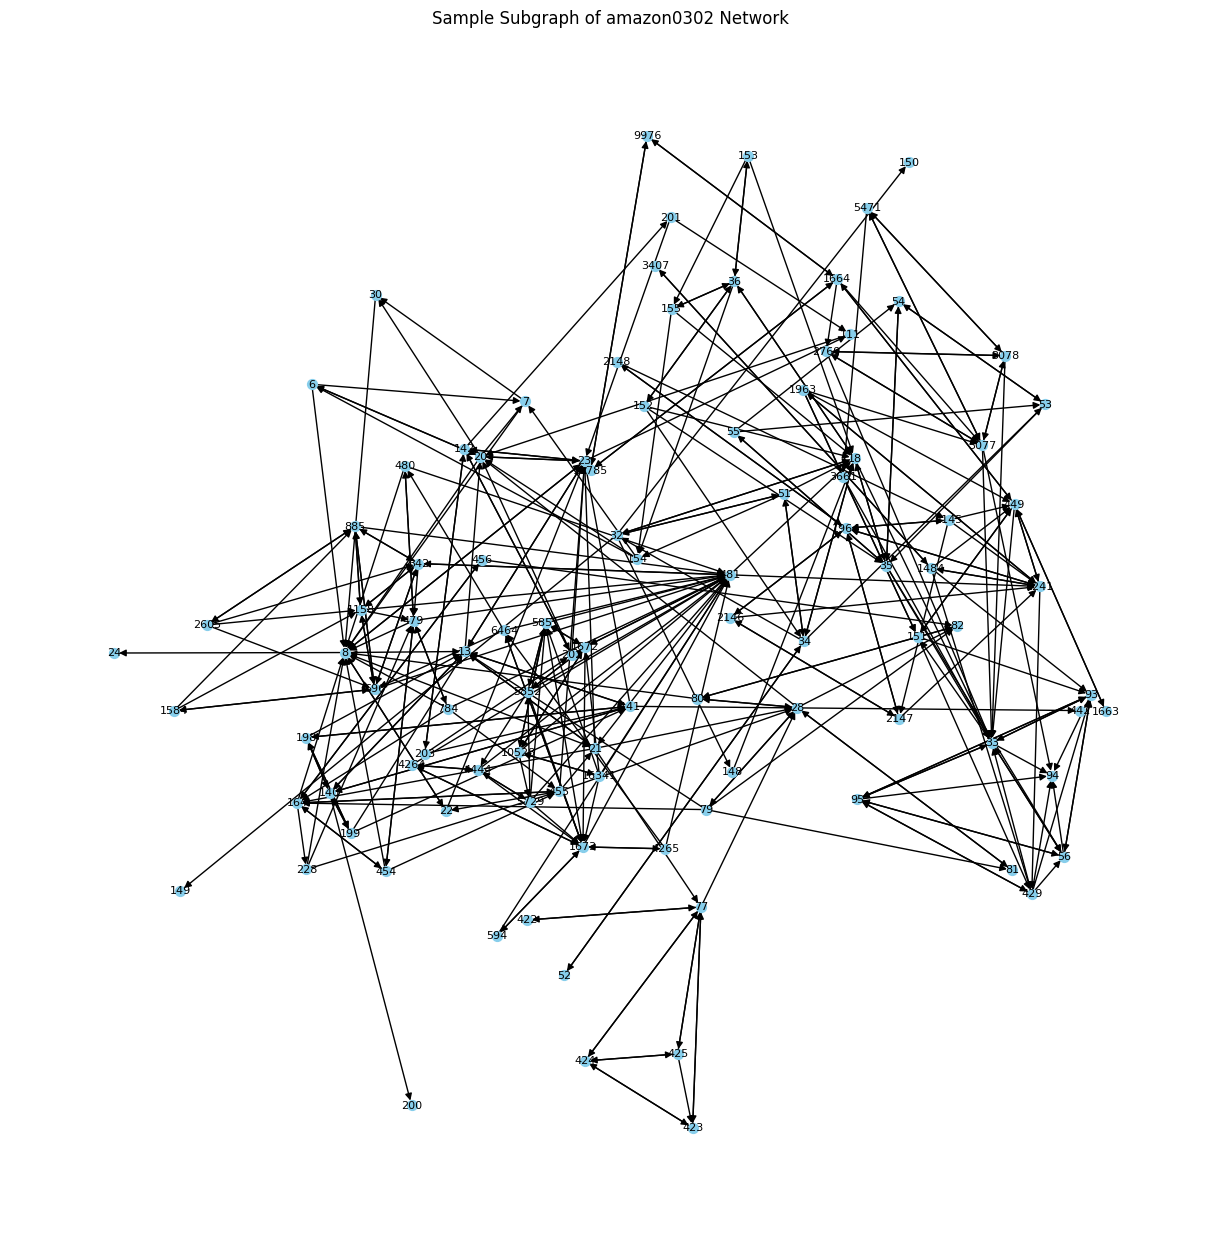

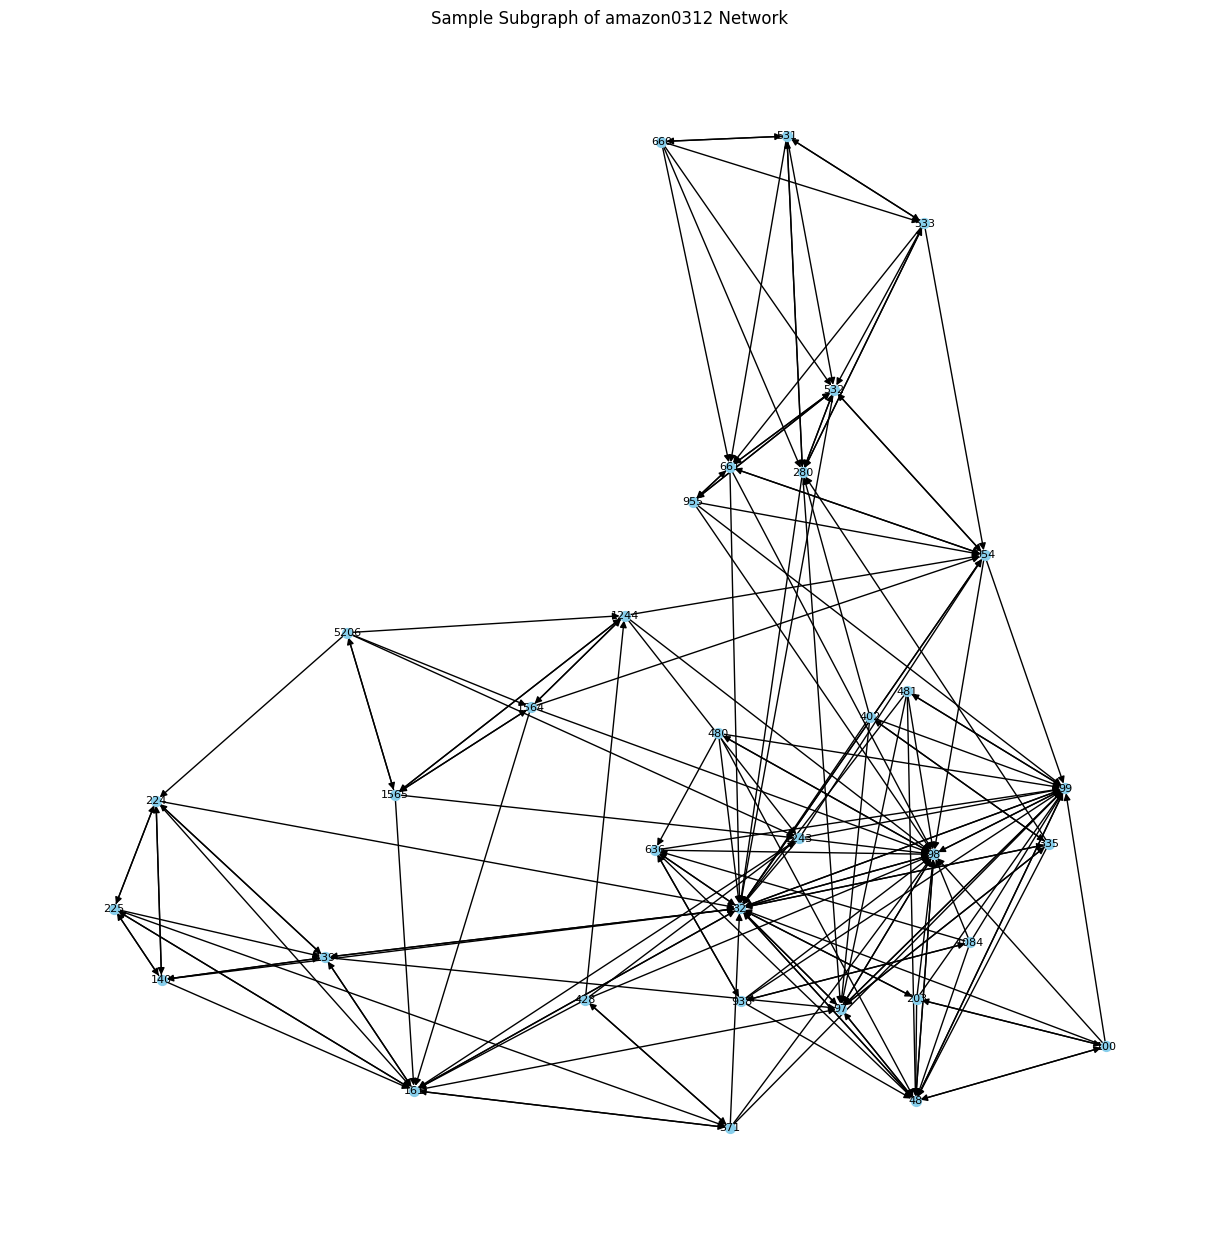

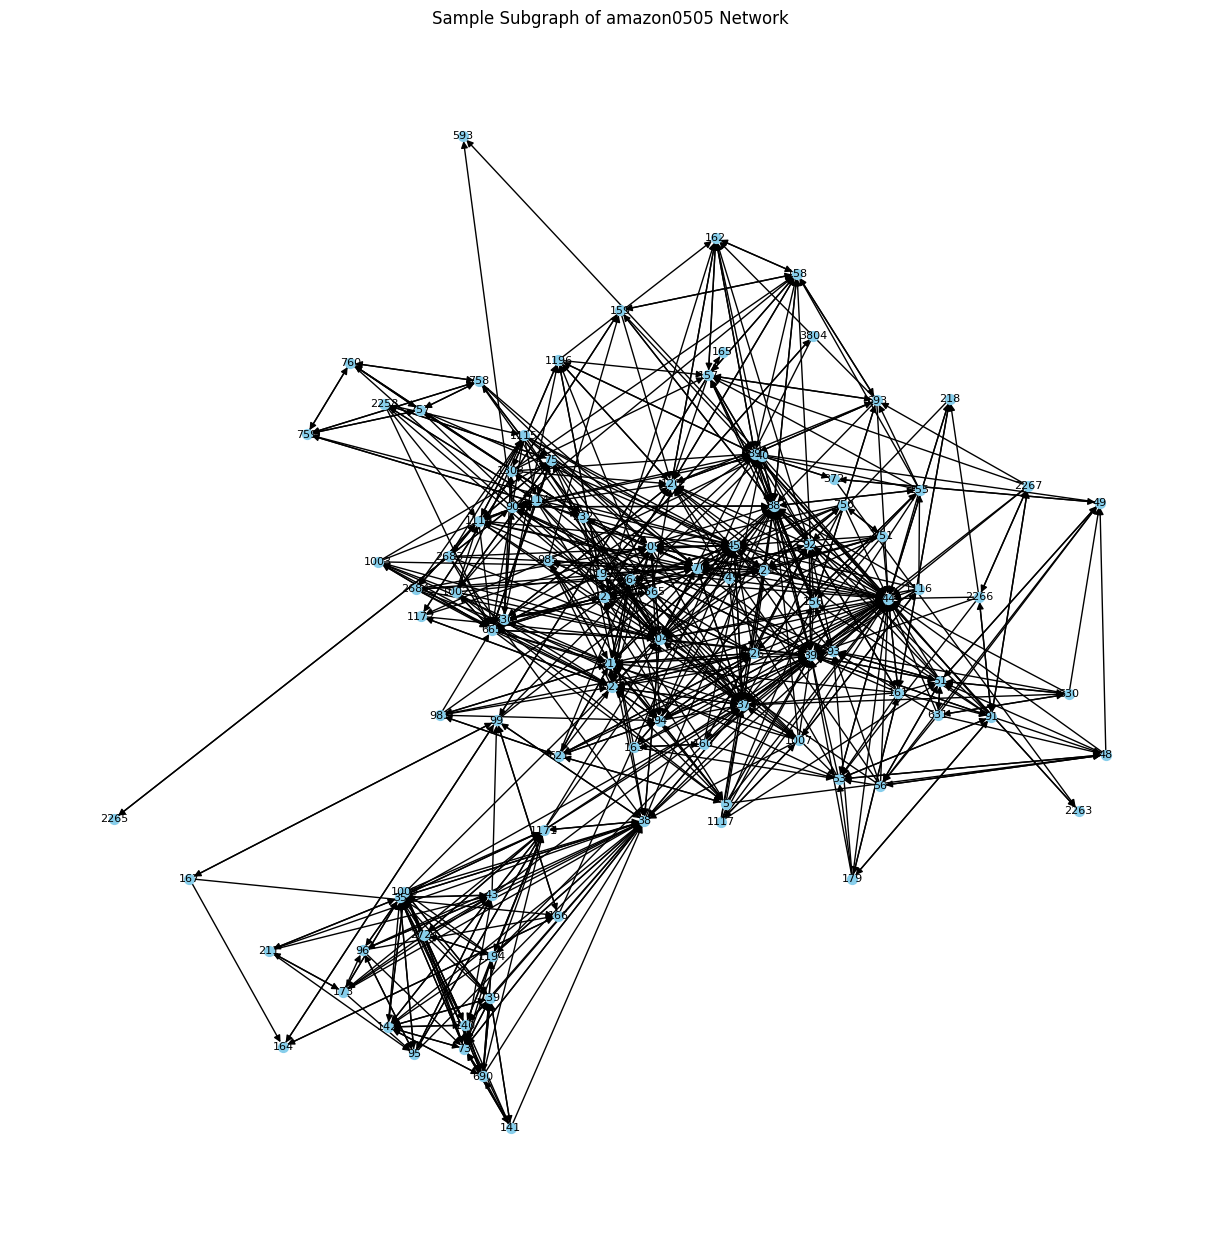

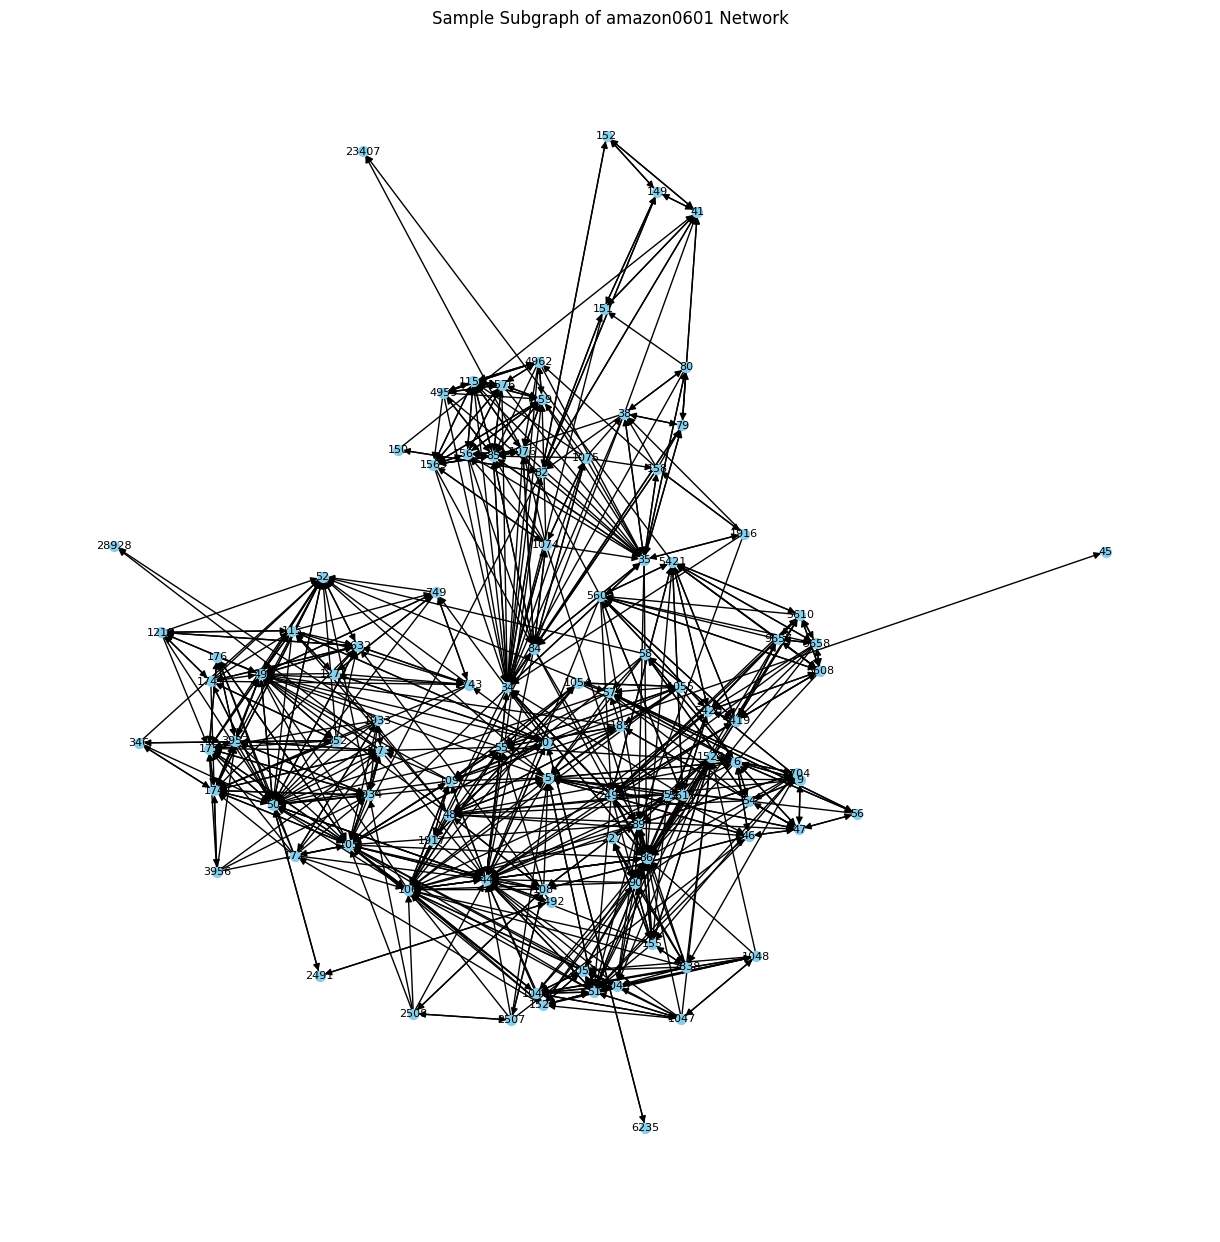

In [14]:
# --- Cell 13: (Optional) Visualization ---
# VERY BASIC visualization.  For large graphs, you'll need a better approach.

# Make sure %matplotlib inline is at the top of the notebook
import matplotlib.pyplot as plt
%matplotlib inline

print("\nPerforming basic graph visualization (limited sample)...")

for graph_name, analysis in graph_analyses.items():
    if 'sample_subgraph' in analysis:
        if analysis["sample_subgraph"] is not None:
            # Get the sample subgraph
            sample_graph = analysis['sample_subgraph']

            plt.figure(figsize=(12, 12))  # Adjust figure size as needed

            # Use a layout algorithm that works well for sparse graphs
            pos = nx.spring_layout(sample_graph, k=0.5, iterations=50)  # Adjust parameters
            # You might also try: nx.spectral_layout, nx.random_layout, nx.shell_layout

            nx.draw(sample_graph, pos, with_labels=True, node_size=50, node_color="skyblue", font_size=8)
            plt.title(f"Sample Subgraph of {graph_name} Network")
            plt.savefig(f"{graph_name}_subgraph.png") # Save the figure to a file
            plt.show()
        else:
            print(f"Sample subgraph for {graph_name} was None, skipping visualization")
    else:
        print(f"No sample subgraph available for visualization of {graph_name}.")